<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Predicting-which-water-pumps-are-faulty-in-Tanzania" data-toc-modified-id="Predicting-which-water-pumps-are-faulty-in-Tanzania-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Predicting which water pumps are faulty in Tanzania</a></span></li><li><span><a href="#Data-processing" data-toc-modified-id="Data-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data processing</a></span><ul class="toc-item"><li><span><a href="#Useful-project-independent-functions" data-toc-modified-id="Useful-project-independent-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Useful project-independent functions</a></span></li><li><span><a href="#Project-dependent-functions" data-toc-modified-id="Project-dependent-functions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Project-dependent functions</a></span></li><li><span><a href="#Import-all-the-data,-split-it-and-prepare-it" data-toc-modified-id="Import-all-the-data,-split-it-and-prepare-it-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Import all the data, split it and prepare it</a></span></li></ul></li><li><span><a href="#ML-modeling" data-toc-modified-id="ML-modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ML modeling</a></span><ul class="toc-item"><li><span><a href="#Model-Selection" data-toc-modified-id="Model-Selection-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Model Selection</a></span></li><li><span><a href="#Training-the-models-on-the-full-data-set" data-toc-modified-id="Training-the-models-on-the-full-data-set-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Training the models on the full data set</a></span></li><li><span><a href="#Predictions-from-the-different-ensembles" data-toc-modified-id="Predictions-from-the-different-ensembles-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Predictions from the different ensembles</a></span></li></ul></li><li><span><a href="#Ideas-for-improvement" data-toc-modified-id="Ideas-for-improvement-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Ideas for improvement</a></span></li></ul></div>

## Predicting which water pumps are faulty in Tanzania

This is a write-up of my solution to a *[DrivenData](https://www.drivendata.org)* challenge. My objective here was to use messy real world data to construct a predictive model. The goal of this [challenge](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) is to predict water pumps status:

> Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.



Here's a quick look to the database:
 

In [28]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import gc

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None) #to display all data columns.
pd.set_option('display.max_rows', None)

from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_original=pd.read_csv("./training_values.csv",engine='c')
X_test=pd.read_csv("./test.csv",engine='c')
y_original=pd.read_csv("./training_labels.csv",engine='c')

In [46]:
X_original.sample(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
52086,56431,0.0,2013-06-03,Government Of Tanzania,509,Government,38.074458,-4.478217e+00,Islamic Secondary,0,Pangani,Maparakanga,Kilimanjaro,3,3,Same,Kihurio,120,True,GeoData Consultants Ltd,Water authority,NaN,NaN,1967,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe multiple,communal standpipe
55874,31157,0.0,2013-02-16,Dwsp,0,DWE,0.000000,-2.000000e-08,Igolola,0,Lake Victoria,Busumagu,Mwanza,17,1,Magu,Nkungulu,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
3957,37647,0.0,2013-01-18,Government Of Tanzania,422,District Water Department,38.021039,-1.054436e+01,Kwa Gelioni,0,Ruvuma / Southern Coast,Sebuleni,Lindi,8,3,Nachingwea,Kilima Rondo,150,True,GeoData Consultants Ltd,VWC,Kilimarondo,False,0,other,other,other,vwc,user-group,never pay,never pay,unknown,unknown,insufficient,insufficient,hand dtw,borehole,groundwater,communal standpipe multiple,communal standpipe
2471,8229,200.0,2013-02-08,Rwssp,931,DWE,36.304454,-1.056984e+01,Kwa Athuman Pumbe,0,Ruvuma / Southern Coast,Minazini,Ruvuma,10,5,Namtumbo,Luchili,1000,True,GeoData Consultants Ltd,WUG,NaN,False,2009,swn 80,swn 80,handpump,wug,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777e+00,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
44331,18912,500.0,2011-03-12,I Wash,383,Local te,37.744745,-6.000461e+00,Kwa Mzee Haji,0,Wami / Ruvu,Chalongwe,Morogoro,5,6,Mvomero,Kanga,1,True,GeoData Consultants Ltd,VWC,NaN,True,2011,other - rope pump,rope pump,rope pump,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
50739,8887,0.0,2011-03-25,Kilindi District Co,0,DWE,37.763906,-5.458961e+00,Kwa Mwalimu,0,Pangani,Amani,Tanga,4,7,Kilindi,Msanja,1,True,GeoData Consultants Ltd,VWC,NaN,False,1985,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
55189,66656,500.0,2013-11-02,Danida,547,DANIDA,34.655099,-1.101906e+01,Kwa Mzee Yagalayagala,0,Lake Nyasa,Azimio,Ruvuma,10,3,Mbinga,Kihagara,60,True,GeoData Consultants Ltd,VWC,DANIDA,True,1992,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
56007,38885,0.0,2011-07-17,NaN,0,NaN,33.803057,-9.173412e+00,Ofisi Ya Kijiji,0,Lake Nyasa,Ipoma,Mbeya,12,4,Rungwe,Mpondo,0,True,GeoData Consultants Ltd,VWC,N,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,fluoride,fluoride,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
45676,64757,0.0,2011-07-18,Danida,0,Central government,33.863565,-9.531200e+00,Kwa Totala Mwakalambili,0,Lake Nyasa,Masebe,Mbeya,12,3,Kyela,Mwaya,0,True,GeoData Consultants Ltd,VWC,Sinyanga water supplied sch,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe


In [49]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [83]:
y_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [84]:
y_original['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

##  Data processing


Most of the working time was devoted to data cleaning and feature engineering. The database contains 59400 rows with 40 features. An understanding of each feature and its role was important to clean the database, moreover many features had inconsistent conventions (regarding e.g. the treatment of missing values), clerical typos, vast number of categorical data, and lots of missing values (some features had up to 70% missing values).

After an extensive exploration of the data and and assessments of different strategies, I settled on the following solution:


* Some features are redundant and offer the same information (highly correlated): keep only the most reliable one (e.g. the one having less outliers, missing values). Drop features which are obviously useless (e.g. 'id')


* Unify the treatment of Nulls, Nans, missing values and outliers throughout the database.


* Split the data into training and validation sets. Since the target values are unbalanced we perform a stratified splitting to avoid biasing the algorithms. 


* Some features appear to be intuitively crucial (like location of the pump) yet they contained a large number of missing or wrong values (e.g. around 35% for the population using the pump and construction year). So I followed the following strategies to fill in the missing information:

 * Use the available spatial information (regions, and district within regions) to impute by mean the features which have a strong location dependence. I wrote a generic pandas wrapper to take care of this, `imputeNaN_by_mean_per_region(df, features_to_impute, region_feature)`. E.g. `imputeNaN_by_mean_per_region(X_train,['longitude','latitude'] ,['region','district_code'])` imputes the features `'longitude'` and `'latitude'` from the dataframe `X_train` by their mean per district in each region. When this is not enough (all the values per district are NaNs), `imputeNaN_by_mean_per_region(X_train,['longitude','latitude'] ,'region')` does the same with less granularity.
 
 * The results of this are satisfying (by contrasting with maps of Tanzania and its administrative divisions) however this procedure doesn't work for some other important features (`'gps_height'`,`'population'`,`'construction_year'`)  because data from entire regions are missing. Imputing with the national mean leads to a strongly unbalanced databased. To remedy this I considered the following strategy: Create a new regional feature which has less granularity than the administrative regions (there are 21 in the database), to induce overlap between regions containing valid data. I have first calibrated my code by reproducing the administrative regions of Tanzania using K-means algorithm with 21 centroids. Once I got a satisfying overlap between the fake regions and the real ones, I reduced the number of centroids until I got regions with a good number of non-Null entries. I settled for 10 centroids. I used these 10 fake regions to impute all the missing values, `imputeNaN_by_mean_per_region(X_train, ['gps_height','population','construction_year'], 'cluster10')`.

 * Use information on the pump to impute categorical data related to the maintenance/construction using the most frequent categories. The features `'funder'` and `'installer'` are imputed using the "region" `'extraction_type_class'`: `imputeNaN_by_freq_per_region(X_train,['funder','installer'] ,'extraction_type_class')`

 * Note on imputing: I have divided the data set into a training and a validation set before pre-processing the data. I start by preprocessing the training data set (this is where the 10 new regions are defined).  For the preprocessing of validation/test data  I use information from the training data set (since this is an information we already had) to impute missing values. This should avoid data leakage and over-fitting. Similarly, once the models are fixed I process the test data using the full data set as a priori knowledge.


* I created two more features: `operation_time` (time lapse between the construction year and the record date) and `month` (month when the inspection of the pump took place, to take into account some possible seasonal effect).
 
 
* It is worth noting some other features I tried but which didn't lead to significant improvements: among these cluster_400 created 400 fake regions. The spatial features have the highest F1 score, so I tried to improve the algorithms by providing sub-district regions. However this has slowed down the computation without leading to significant improvement. I have also tried 3D clusters using the height parameter, but while the F1 score of these features was high, the overal improvement was not great. Distinguishing local from international funders didn't lead to any improvement either.


* Last but not least, I label-encoded the categorical features without binning them. Since I was planning on using tree-based algorithms one-hot encoding was not necessary.
 

* Finally we end up with 18 clean and independent features to model.



### Useful project-independent functions

In [29]:
from sklearn.model_selection import cross_val_score


def imputeNaN_by_mean_per_region(df,features,region_feature):
    """ Given a DF, this function groups the list 'features' by 'region_feature' then imputes
    NaNs by mean in each region.
    To impute using sub-regions of region_feature, pass region_feature as a list e.g.
    
    imputeNaN_by_mean_per_region(df,['source','height'],['region','sub-district'])

    V0.2_2019"""
    df_temp=df.copy()
    
    for feature in features:
        filling=df_temp.groupby(region_feature)[feature].transform("mean")
        df_temp[feature]=df_temp[feature].fillna(filling)
        if df_temp[feature].isnull().any().any(): print(f' Warning: [imputeNaN_by_mean_per_{region_feature}] Feature {feature} still has some NaNs.')

    return df_temp

def imputeNaN_by_freq_per_region(df,features,region_feature):
    """ Given a DF, this function groups the columns 'features' by 'region_feature' then imputes
    NaNs by most frequent value in each region. Useful for categorical data. V0.3_2019"""    
    df_temp=df.copy()
    
    for feature in features:
        filling=df_temp.groupby(region_feature)[feature].transform(lambda x: x.value_counts().index[0])
        df_temp[feature]=df_temp[feature].fillna(filling)
        if df_temp[feature].isnull().any().any(): print(f' Warning: [imputeNaN_by_freq_per_{region_feature}] Feature {feature} still has some NaNs.')

    return df_temp


def add_cluster(X_train,X_test, features, k,name):
    """ Creat k-means cluster out of 'features' and hierarchically add
    the new feature k-cluster to train/val/test. V0.2_2019"""
    Xtrain=X_train.copy()
    Xtest=X_test.copy()
    
    kmeans = KMeans(n_clusters=k,random_state=99)
    clusterer = kmeans.fit(Xtrain[features].values)
            
    clusters_tr= clusterer.predict(Xtrain[features].values)
    clusters_ts= clusterer.predict(Xtest[features].values)
    
    Xtrain=pd.concat([Xtrain.reset_index(drop=True), pd.DataFrame({f'{name}':clusters_tr})], axis=1)
    Xtest=pd.concat([Xtest.reset_index(drop=True), pd.DataFrame({f'{name}':clusters_ts})], axis=1)
    #drop=True avoids creation of many indices. Pandas can also generate an error after a sequence of reset_index(),
    
    return Xtrain,Xtest

def cut_levels(df_feature, threshold, new_value):
    """ Bins values which appear <= threshold in df.feature into a new_value.V0.1_2019"""
    x = df_feature.copy()
    value_counts = x.value_counts()
    labels = value_counts.index[value_counts <= threshold]
    x[np.in1d(x, labels)] = new_value
    return x

### Project-dependent functions

In [30]:
def drop_useless_features(df):
    """Project-dependent: Drops columns which are note useful."""
    df_temp=df.copy()
    not_important=['amount_tsh', 'region_code','recorded_by','source','payment',
                  'waterpoint_type','quantity' ,'water_quality','management',
                   'id','num_private','extraction_type_group','permit',
                   'wpt_name','scheme_management','scheme_name',
                   'public_meeting','waterpoint_type_group',
                   'subvillage','ward','lga','extraction_type']
    df_temp=df_temp.drop(not_important, axis=1)
    return df_temp 

def convert_invalid_to_nan(df):
    """Project-dependent: replaces all invalid entries by NaN."""
    df_temp=df.copy()
    columns=['population','longitude','latitude','gps_height','construction_year'] 
    df_temp[columns]=df_temp[columns].replace(0, np.nan)
    
    df_temp['latitude']=df_temp['latitude'].replace(-2.000000e-08, np.nan)
    df_temp['funder']=df_temp['funder'].replace('0',np.nan)
    return df_temp


def add_operation_time(df):
    """Project-dependent: creates new feature: operation time since construction."""
    df_temp=df.copy()
    df_temp['date_recorded']=pd.to_datetime(df_temp['date_recorded'])
    df_temp['date_construction']=pd.to_datetime(df_temp['construction_year'],format='%Y',errors='coerce')
    df_temp['operation_time']=(df_temp['date_recorded']-df_temp['date_construction'])/np.timedelta64(1, 'M')    
    return df_temp


In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans 

def prepare_data(train_data,test_data):
    """Applies all necessary steps to prepare the data for ML.
    Some operations apply to DF's individually (e.g., dropping of columns) but others
    work in a sequence (e.g., cluster features).    """
    
    print("\n# Preparing data ...\n")
    Xtrain=train_data.copy()
    Xtest=test_data.copy()
        
#
    print("-- Drop unimportant features")
    Xtrain,Xtest=map(drop_useless_features,[Xtrain,Xtest])
    
#    
    print("-- Convert all invalid values to NaNs")
    Xtrain,Xtest=map(convert_invalid_to_nan,[Xtrain,Xtest])  
    
#   
    print("-- Impute ['longitude','latitude','funder','installer']")

    Xtrain=imputeNaN_by_mean_per_region(Xtrain,['longitude','latitude'] ,['region','district_code'])
    #some nans remain, impute them using a larger grid: the region.
    Xtrain=imputeNaN_by_mean_per_region(Xtrain,['longitude','latitude'] ,'region')
    
    Xtrain=imputeNaN_by_freq_per_region(Xtrain,['funder','installer'] ,'extraction_type_class')
    #we use input from train data for this:
    Xtraintest=pd.concat([Xtrain,Xtest])
    Xtraintest=imputeNaN_by_mean_per_region(Xtraintest,['longitude','latitude'] ,['region','district_code'])

    Xtraintest=imputeNaN_by_freq_per_region(Xtraintest,['funder','installer'] ,'extraction_type_class')
    Xtest = Xtraintest[-len(Xtest):]
       
#    
    print("-- Impute ['gps_height','population','construction_year'] using Kmeans-10")
    Xtrain,Xtest=add_cluster(Xtrain,Xtest, ['latitude','longitude'], 10,'cluster10')
        
    #impute training data set
    Xtrain=imputeNaN_by_mean_per_region(Xtrain,['gps_height','population','construction_year'] ,'cluster10')
    
    #impute validation data set using training+val
    Xtraintest=pd.concat([Xtrain,Xtest])
    Xtraintest=imputeNaN_by_mean_per_region(Xtraintest,['gps_height','population','construction_year'] ,'cluster10')    
    Xtest = Xtraintest[-len(Xtest):]
    
     
    if not Xtraintest.isnull().any().any(): print(f'All data has been successfuly imputed.')

        
###     
#    print("-- Add 800 geo 2D clusters")
#    Xtrain,Xtest=add_cluster(Xtrain,Xtest, ['latitude','longitude'], 800,'2d_800')
###        
    
#
    print("-- Add month of record")

    Xtrain['month'],Xtest['month']=map(lambda x:x['date_recorded'].apply(lambda x: int(x.split('-')[1])),[Xtrain,Xtest])

#
    print("-- Add operation time")
    Xtrain,Xtest=map(add_operation_time,[Xtrain,Xtest])
    Xtrain,Xtest=map(lambda x:x.drop(['cluster10','date_recorded','construction_year','date_construction'], axis=1),[Xtrain,Xtest])
#    Xtrain,Xval,Xtest=map(lambda x:x.drop(['date_recorded','date_construction'], axis=1),[Xtrain,Xval,Xtest])


#        
    print("-- Encode categorical features")
    #use full data to avoid collisions.
    cat_columns =list(Xtrain.select_dtypes(['object']).columns)

    Xtraintest=pd.concat([Xtrain,Xtest])
    Xtraintest[cat_columns] = Xtraintest[cat_columns].apply(lambda col: LabelEncoder().fit_transform(col))
        
    Xtrain   =Xtraintest[:len(Xtrain)]
    Xtest= Xtraintest[-len(Xtest):]
    
    print("\nDone.")
    return [Xtrain, Xtest]


In [32]:
def prepare_targets(target_data):
    """Simply label-encodes the y data."""
    
    print("\n# Preparing targets ...\n")
    
    print("-- Encode categorical features")

    y_prepared=LabelEncoder().fit_transform(target_data['status_group'][:, np.newaxis].ravel())
        
    print("\nDone.")

    return y_prepared


### Import all the data, split it and prepare it

In [33]:

split_frac=0.15
X_train, X_val,y_train, y_val = train_test_split(X_original,y_original, test_size=split_frac, random_state=99,stratify=y_original['status_group'])

print(f'Train={X_train.shape} | Val={X_val.shape}')


Train=(50490, 40) | Val=(8910, 40)


In [34]:

X_train, X_val = prepare_data(X_train, X_val)


y_train=prepare_targets(y_train)
y_val=prepare_targets(y_val)



# Preparing data ...

-- Drop unimportant features
-- Convert all invalid values to NaNs
-- Impute ['longitude','latitude','funder','installer']
-- Impute ['gps_height','population','construction_year'] using Kmeans-10
All data has been successfuly imputed.
-- Add month of record
-- Add operation time
-- Encode categorical features

Done.

# Preparing targets ...

-- Encode categorical features

Done.

# Preparing targets ...

-- Encode categorical features

Done.


In [59]:
X_train_full, X_test_prep = prepare_data(X_original, X_test)

y_train_full=prepare_targets(y_original)


# Preparing data ...

-- Drop unimportant features
-- Convert all invalid values to NaNs
-- Impute ['longitude','latitude','funder','installer']
-- Impute ['gps_height','population','construction_year'] using Kmeans-10
All data has been successfuly imputed.
-- Add month of record
-- Add operation time
-- Encode categorical features

Done.

# Preparing targets ...

-- Encode categorical features

Done.


In [15]:
X_train.to_csv("X_train_prepared.csv", index=False)
X_val.to_csv("X_val_prepared.csv", index=False)
pd.DataFrame(y_train, columns=['target']).to_csv("y_train_prepared.csv", index=False)
pd.DataFrame(y_val, columns=['target']).to_csv("y_val_prepared.csv", index=False)


In [35]:

print('\n\n shapes:')
print(f'X_Train={X_train.shape} | X_Val={X_val.shape} | X_Test={X_test.shape}')
print(f'Y_Train={y_train.shape} | Y_Val={y_val.shape}')


X_train.dtypes



 shapes:
X_Train=(50490, 18) | X_Val=(8910, 18) | X_Test=(14850, 40)
Y_Train=(50490,) | Y_Val=(8910,)


funder                     int64
gps_height               float64
installer                  int64
longitude                float64
latitude                 float64
basin                      int64
region                     int64
district_code              int64
population               float64
extraction_type_class      int64
management_group           int64
payment_type               int64
quality_group              int64
quantity_group             int64
source_type                int64
source_class               int64
month                      int64
operation_time           float64
dtype: object

In [29]:
X_train.head()

,funder,gps_height,installer,longitude,latitude,basin,region,district_code,population,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,source_class,month,operation_time
0,1598,1329.032438,442,34.197274,-2.964533,4,17,1,532.042575,1997.347871,1,4,4,2,1,5,0,1,192.989589
1,506,1328.441296,1849,32.238386,-2.480578,4,13,5,343.862348,2001.810700,1,4,2,2,0,5,0,8,127.082692
2,485,1408.000000,229,37.178725,-3.222180,5,6,5,90.000000,1999.000000,0,4,5,2,1,6,0,3,170.024025
3,292,519.000000,384,34.638345,-11.030694,1,16,3,96.000000,1992.000000,0,4,1,2,1,6,0,10,261.032054
4,696,1328.441296,442,30.707507,-1.061360,4,4,1,343.862348,2001.810700,1,4,2,2,1,5,0,8,127.082692


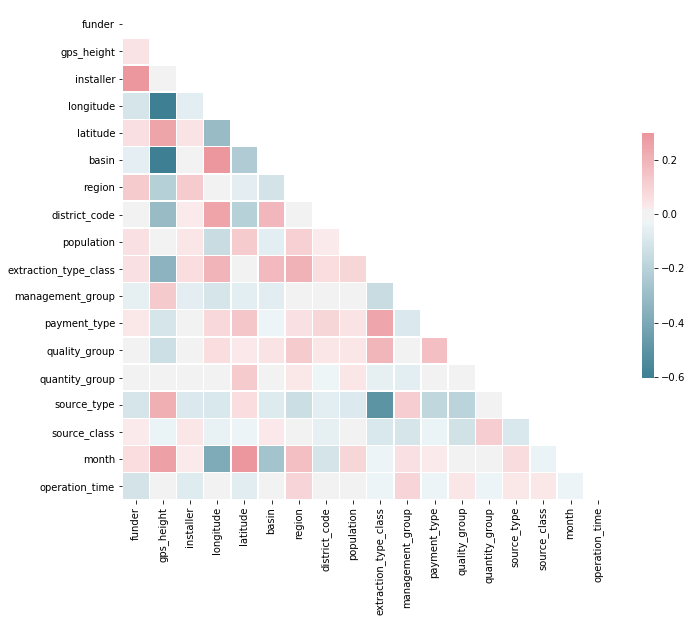

In [36]:
import seaborn as sns

# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## ML modeling

I considered the following classifiers: Random Forest, XGBoost, LightGBM, AdaBoost, CatBoost, (Sci-kit's) Gradient Boosting, and K-Neighbors.

I start by exploring the predictions/parameters of these classifiers manually as well as systematically in  restricted areas (using grid-searches) to pinpoint the most interesting regions in the hyperspace of parameters. By order of importance, different parameters are tuned and their relevance gauged. Hyper-parameters were then fine-tuned using randomized search with 5-fold  cross-validation for each classifier. 

As a result, AdaBoost, CatBoost, (Sci-kit's) Gradient Boosting, and K-Neighbor were performing rather poorly (and to the exception of KN they were also much slower) even when considering additional tweaks (like bagging AdaBoost). The final short-list consisted of only the first three classifiers (Random Forest, XGBoost, LightGBM) which offered  good performances at reasonable execution times (of these XGBoost was the best with a slight advantage). I assessed the accuracy of these models on the validation data set and with cross-validation.

After some more focused tuning I considered different ensembles (see below). It turns out that the best performing stack consists of the three models trained on the full data set and  gave the highest public rating; a top 10% score of 0.8168 (best being 0.8286).

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

### Model Selection 

In [48]:
LGB_params={
    'max_depth': [19],
    'feature_fraction':[0.5,0.6,0.55],
    'learning_rate' : [0.45],
    'num_leaves': [140,150,160],
    'n_estimators':[90]
#    'reg_lambda' : [1,2] 
}

RF_params={
    'max_depth':[62,61],
    'min_samples_leaf':[3,4],
    'min_samples_split':[2],
    'n_estimators':[72,73,74]  
}

XGB_params= {
    'learning_rate': [0.01,0.02,0.03,0.04],
    'max_depth': [22],
    'reg_alpha':[0]
#    'reg_alpha': [0,1],
#    'reg_lambda': [1,2],
#    'n_estimators':[200,210,220],
}
 
#GB_params= {
#    'learning_rate':[0.08,0.09, 0.1,0.12,0.15],
#    'max_depth': [10,15,20],    
#    'n_estimators':[50,80,100,110]
#}


#KNN_params={
#    'n_neighbors': [5,20,25,30,35],
#    'leaf_size': [2,20,30,50]}



Classifiers=[
    LGBMClassifier(  bagging_fraction=.9,
                bagging_freq=5,
                feature_fraction=0.5,    
                min_child_samples=5,
                min_child_weight=0.001,
                min_split_gain=0.0,
                n_jobs=-1,
                num_class=3,
                num_threads=8,
                objective='multiclass',
                reg_alpha=1.0,
                reg_lambda=2,
                seed=300,
                silent=True, 
                subsample=1.0,
                subsample_for_bin=200000,
                subsample_freq=0, 
                verbosity=1),
    RandomForestClassifier(bootstrap=False, criterion='gini',n_jobs=4,max_leaf_nodes=None,max_features=4,random_state=None,verbose=0),
#    GradientBoostingClassifier(),
#    KNeighborsClassifier(n_jobs=4, p=1, weights='distance'),
    XGBClassifier(  objective='multi:softprob',
                n_jobs=4,
                num_class=3,
                gamma=1,
                min_child_weight=4,
                random_state=0,
                reg_alpha=0,
                reg_lambda=1,
                n_estimators=200,
                subsample=0.9,
                colsample_bytree=0.7) 
]

Classifiers_params=[
    LGB_params,
    RF_params,
#    GB_params,
#    KNN_params,
    XGB_params]

In [49]:
Best_Classifiers=[]
CV_scores=[]
for clf,params in tqdm(zip(Classifiers,Classifiers_params)):
    print(clf)
    kfold = KFold(n_splits=3, shuffle = True)
    clf_rnd = RandomizedSearchCV(clf, 
                         param_distributions = params,
                         cv = kfold,  
                         n_iter = 5, 
                         scoring = 'accuracy', 
                         error_score = 0, 
                         n_jobs = 4)
    clf_rnd.fit(X_train, y_train)   
    Best_Classifiers+=[clf_rnd.best_estimator_]
    CV_scores+=[clf_rnd.cv_results_]
 


0it [00:00, ?it/s]

LGBMClassifier(bagging_fraction=0.9, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=-1, min_child_samples=5, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=4, num_class=3,
        num_leaves=31, num_threads=8, objective='multiclass',
        random_state=None, reg_alpha=1.0, reg_lambda=2, seed=300,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0, verbosity=1)



1it [03:10, 190.36s/it]

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)



2it [03:59, 148.11s/it]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=4, missing=None, n_estimators=200,
       n_jobs=4, nthread=None, num_class=3, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)



3it [23:54, 462.11s/it]

In [40]:
for score in CV_scores:
    print(f'Test score = {np.mean(score["mean_test_score"])} +/- {np.mean(score["std_test_score"])}')
    print('~~~~')

Test score = 0.7948900772430184 +/- 0.0027904880980733405
~~~~
Test score = 0.8040720934838582 +/- 0.0017163659048650564
~~~~
Test score = 0.8039136462665875 +/- 0.003310658672786951
~~~~


In [84]:
LGB_best = LGBMClassifier(bagging_fraction=0.9, bagging_freq=5, boosting_type='gbdt',
         class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
         importance_type='split', learning_rate=0.45, max_depth=19,
         min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=90, n_jobs=-1, num_class=3, num_leaves=150,
         num_threads=8, objective='multiclass', random_state=None,
         reg_alpha=1.0, reg_lambda=2, seed=300, silent=True, subsample=1.0,
         subsample_for_bin=200000, subsample_freq=0, verbosity=1)
RF_best= RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=61, max_features=4, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=4, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=72, n_jobs=4,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False)
XGB_best= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_delta_step=0,
        max_depth=22, min_child_weight=4, missing=None, n_estimators=200,
        n_jobs=4, nthread=None, num_class=3, objective='multi:softprob',
        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=None, silent=True, subsample=0.9)

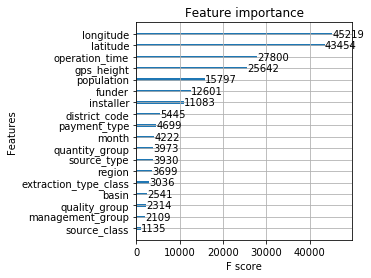

In [55]:
fig=plt.figure()
plot_importance(Best_Classifiers[-1], ax=plt.gca())
fig.subplots_adjust(left=0.4)

In [63]:
#Assessment of accuracy on the validation set using early stopping:
XGB_best.fit(X_train, y_train, 
            eval_set=[(X_val, y_val)],
            verbose=100, 
            early_stopping_rounds=50
             )
                  
XGB_best.score(X_val, y_val)
 

[0]	validation_0-merror:0.222896
Will train until validation_0-merror hasn't improved in 100 rounds.
[100]	validation_0-merror:0.186869
Stopping. Best iteration:
[65]	validation_0-merror:0.185073



0.8149270482603816

In [62]:
#Relevant classification metrics
from sklearn.metrics import classification_report

y_pred=XGB_best.predict(X_val).flatten()

print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.91      0.85      4839
          1       0.64      0.28      0.38       647
          2       0.85      0.78      0.81      3424

avg / total       0.81      0.81      0.80      8910



### Training the models on the full data set

Training on the full data set without cross-validation:

In [ ]:
mdl_path = './models'


LGB_best.fit(X_train_full.values,y_train_full)
joblib.dump(LGB_best, f'{mdl_path}/lgb_full.mdl', compress=True)

RF_best.fit(X_train_full.values,y_train_full)
joblib.dump(RF_best, f'{mdl_path}/rf_full.mdl', compress=True)

XGB_best.fit(X_train_full.values,y_train_full)
joblib.dump(XGB_best, f'{mdl_path}/xgb_full.mdl', compress=True)


Using cross-validation and early stopping, I train k(=5) variants of each model and save them on disk.

In [208]:
import gc
from sklearn.externals import joblib
mdl_path = './models'




def train_mdl(model,Xtrain,ytrain,name,k=10,earlystop=50):
    """ Train 'model' on X,y_train using 'k'-Stratified-cross-validation.
    Calls fit_mdl() for each iteration. Prints mean score (here accuracy) at the end.
    """    
    df_index = np.array(Xtrain.index)                     
    
    cv_result=0
        
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    skf.get_n_splits(Xtrain, ytrain)
    
    print('\nModel Fitting...')
    for counter, ids in enumerate(skf.split(df_index, ytrain)):
        print('\nFold {}'.format(counter+1))
        X_fit, y_fit = Xtrain.values[ids[0]], ytrain[ids[0]]
        X_cval, y_cval = Xtrain.values[ids[1]], ytrain[ids[1]]
        
        cv_result += fit_mdl(model,X_fit, y_fit, X_cval, y_cval, name+str(counter+1),earlystop)
        
        del X_fit, X_cval, y_fit, y_cval
        gc.collect()
    
    mean_score  = cv_result/k
    print(f'\n Cross-val Accuracy: {mean_score}')
    return 


def fit_mdl(model,X_fit, y_fit, X_cval, y_cval, name,earlystop=50):
    """ Fit 'model' on X,y_fit and validate on X,y_cval.
    Save the model in mdl_path/name.
    Returns CV score.
    """
        
    model.fit(X_fit, y_fit, 
                eval_set=[(X_cval, y_cval)],
                verbose=earlystop,  
                early_stopping_rounds=earlystop )
                  
    cv_score = model.score(X_cval, y_cval)#model.predict_proba(X_val)
    
    #Save the Model
    save_to = f'{mdl_path}/{name}.mdl'
    
    joblib.dump(model, save_to, compress=True)

    return cv_score
    

In [ ]:
train_mdl(XGB_best,X_train_full,y_train_full,name='xgb_fold_',k=5,earlystop=50)

In [ ]:
train_mdl(LGB_best,X_train_full,y_train_full,name='lgb_fold_',k=5,earlystop=100)

In [ ]:
train_mdl(RF_best,X_train_full,y_train_full,name='rf_fold_',k=5,earlystop=100)

### Predictions from the different ensembles

The different possibilities to stack the models together can be considered as a new hyperparameter to tune (using cross-validation). I tried different possibilities tuning: number and types of models to uniformly (i.e., unweighted sum) stack, different ways to combine predictions, and different trainings.

Performance (i.e. accuracy in this case) is measured with cross-validation.
For the main variants, I have the following performances:

- 5 CV (LGB+XGB+RF) with soft voting: 0.7857
- 5 CV (LGB+XGB+RF) with hard voting: 0.8147
- 5 CV (XGB+RF) with hard voting: 0.8150
- (XGB + RF + LGB) on full data set: 0.8168
- (XGB + RF) on full data set: 0.8156
- Everything: 0.8153

In [210]:
from glob import glob
from scipy.stats import mode

def predictions(saved_mdl,X_test,voting):
    """Calculate predictions of the saved models (e.g., saved_mdl='xgb_*.mdl') on the test set.
    
    voting  ='soft' : rounded(mean of votes)
            ='hard' : mode(votes)
    """

    models = glob(mdl_path+'/'+saved_mdl)
    
    preds=[]
    
    print('\nMaking Predictions...\n')
    for counter,mdl_name in enumerate(models):
        print(f'[{counter+1}] Predicting with model {mdl_name}...')

        model = joblib.load(mdl_name)
        preds += [model.predict(X_test.values)]

    if (voting=='soft'):
        preds=np.array(preds)  
        predictions=np.round(preds.mean(axis=0)).astype(int)
    if (voting=='hard'):
        predictions=np.squeeze(mode(preds)[0])

     
    enc = LabelEncoder()
    yt=enc.fit_transform(y_original['status_group'][:, np.newaxis])

    mypredictions=enc.inverse_transform(predictions)


    datasubmission=pd.DataFrame(data=[test_id, mypredictions]).T
    datasubmission.columns=['id','status_group']

    datasubmission.to_csv("submission.csv", index=False)

        

    print('\nDone.')

    return predictions


In [212]:
mypredictions=predictions('*full*.mdl',X_test_prep,"hard")


Making Predictions...

[1] Predicting with model ./models/xgb_full.mdl...
[2] Predicting with model ./models/lgb_full.mdl...
[3] Predicting with model ./models/rf_full.mdl...


/Users/sofiane/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Done.


## Ideas for improvement

Although the goal was not to build the most competitive model, I think that with more time tuning the parameters, this model can lead to a higher score. 

To increase it even further, here are some more ideas to consider:

* Build new features such as: distance from big city, non-linear transformation of lat/long coordinates, spatial grid of transformed coordinates.
* Bin categorical data with large number of categories.


End.